# Breast Cancer Detection using Multiple Instance Learning (MIL)

"Breast Cancer Histopathology Image Classification
and Localization using Multiple Instance Learning" implementation. Dataset is available in the paper.

https://arxiv.org/pdf/2003.00823.pdf

## Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import random
import copy
import torchvision.transforms.functional as TF
from typing import Sequence

In [2]:
RANDOM_SEED = 0

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)
# np.random.seed(RANDOM_SEED)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Downloading dataset

The BreaKHis dataset download and decompression.

Link to the dataset's website:

https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

In [4]:
!wget http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz -O /content/BreaKHis_v1.tar.gz -q
!tar xzf /content/BreaKHis_v1.tar.gz -C /content

## Data Preparation

40x image


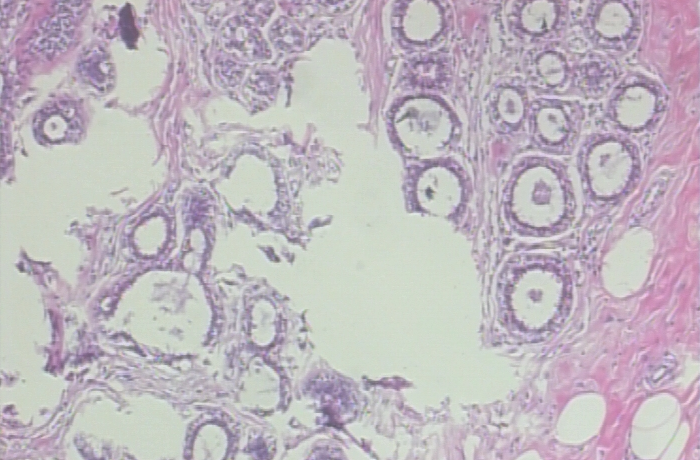

400x image


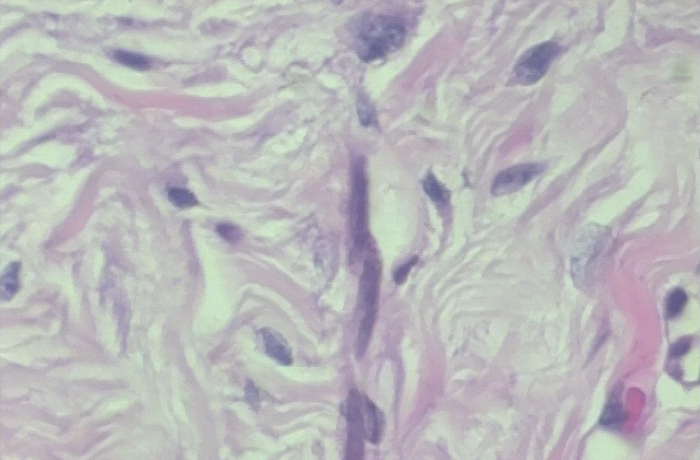

In [5]:
# Creating data set with path, label, magnification
dataset_40X = []
dataset_100X = []
dataset_200X = []
dataset_400X = []

base = "/content/BreaKHis_v1/histology_slides/breast"
benign = "/benign/SOB"
malignant = "/malignant/SOB"
for root, dirs, files in os.walk(os.path.join(base + benign)):
  if files:
    for f in files:
      path = os.path.join(root, f)
      tag = 0 # because we're in benign directory
      mag = f.split('-')[-2]
      match mag:
        case '40':
          dataset_40X.append({'image': Image.open(path), 'tag':tag})
        case '100':
          dataset_100X.append({'image': Image.open(path), 'tag':tag})
        case '200':
          dataset_200X.append({'image': Image.open(path), 'tag':tag})
        case '400':
          dataset_400X.append({'image': Image.open(path), 'tag':tag})
        case _:
          print("ERROR:", "Unknown Magnification")

for root, dirs, files in os.walk(os.path.join(base + malignant)):
  if files:
    for f in files:
      path = os.path.join(root, f)
      tag = 1 # because we're in malignant directory
      mag = f.split('-')[-2]
      match mag:
        case '40':
          dataset_40X.append({'image': Image.open(path), 'tag':tag})
        case '100':
          dataset_100X.append({'image': Image.open(path), 'tag':tag})
        case '200':
          dataset_200X.append({'image': Image.open(path), 'tag':tag})
        case '400':
          dataset_400X.append({'image': Image.open(path), 'tag':tag})
        case _:
          print("ERROR:", "Unknown Magnification")

df_40X = pd.DataFrame(dataset_40X)
df_100X = pd.DataFrame(dataset_100X)
df_200X = pd.DataFrame(dataset_200X)
df_400X = pd.DataFrame(dataset_400X)

print('40x image')
display(df_40X['image'][0])
print('400x image')
display(df_400X['image'][0])

In [18]:
# Train Validation Test split. 80 5 15
x_40_train, x_40_test, y_40_train, y_40_test = train_test_split(
    df_40X['image'],
    df_40X['tag'],
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify = df_40X['tag'],
)
train_40_df = pd.concat([x_40_train, y_40_train], axis=1).reset_index(drop=True)
test_40_df = pd.concat([x_40_test, y_40_test], axis=1).reset_index(drop=True)
x_40_train, x_40_val, y_40_train, y_40_val = train_test_split(
    train_40_df['image'],
    train_40_df['tag'],
    test_size=0.06,
    random_state=RANDOM_SEED,
    stratify = train_40_df['tag']
)
train_40_df = pd.concat([x_40_train, y_40_train], axis=1).reset_index(drop=True)
val_40_df = pd.concat([x_40_val, y_40_val], axis=1).reset_index(drop=True)


x_100_train, x_100_test, y_100_train, y_100_test = train_test_split(
    df_100X['image'],
    df_100X['tag'],
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify = df_100X['tag'],
)
train_100_df = pd.concat([x_100_train, y_100_train], axis=1).reset_index(drop=True)
test_100_df = pd.concat([x_100_test, y_100_test], axis=1).reset_index(drop=True)
x_100_train, x_100_val, y_100_train, y_100_val = train_test_split(
    train_100_df['image'],
    train_100_df['tag'],
    test_size=0.06,
    random_state=RANDOM_SEED,
    stratify = train_100_df['tag']
)
train_100_df = pd.concat([x_100_train, y_100_train], axis=1).reset_index(drop=True)
val_100_df = pd.concat([x_100_val, y_100_val], axis=1).reset_index(drop=True)


x_200_train, x_200_test, y_200_train, y_200_test = train_test_split(
    df_200X['image'],
    df_200X['tag'],
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify = df_200X['tag'],
)
train_200_df = pd.concat([x_200_train, y_200_train], axis=1).reset_index(drop=True)
test_200_df = pd.concat([x_200_test, y_200_test], axis=1).reset_index(drop=True)
x_200_train, x_200_val, y_200_train, y_200_val = train_test_split(
    train_200_df['image'],
    train_200_df['tag'],
    test_size=0.06,
    random_state=RANDOM_SEED,
    stratify = train_200_df['tag']
)
train_200_df = pd.concat([x_200_train, y_200_train], axis=1).reset_index(drop=True)
val_200_df = pd.concat([x_200_val, y_200_val], axis=1).reset_index(drop=True)


x_400_train, x_400_test, y_400_train, y_400_test = train_test_split(
    df_400X['image'],
    df_400X['tag'],
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify = df_400X['tag'],
)
train_400_df = pd.concat([x_400_train, y_400_train], axis=1).reset_index(drop=True)
test_400_df = pd.concat([x_400_test, y_400_test], axis=1).reset_index(drop=True)
x_400_train, x_400_val, y_400_train, y_400_val = train_test_split(
    train_400_df['image'],
    train_400_df['tag'],
    test_size=0.06,
    random_state=RANDOM_SEED,
    stratify = train_400_df['tag']
)
train_400_df = pd.concat([x_400_train, y_400_train], axis=1).reset_index(drop=True)
val_400_df = pd.concat([x_400_val, y_400_val], axis=1).reset_index(drop=True)

In [7]:
class CustomBreaKHis(Dataset):
    def __init__(self, dataframe, transform):
      self.data = dataframe
      self.transform = transform

    def __len__(self):
      return self.data.shape[0]

    def __getitem__(self, index):
      data = self.data.iloc[index]
      tag = data['tag']

      # Creating Patches
      patches = self.create_patch(data['image'])

      # Transforming
      patches = self.transform(patches)

      return  patches, tag

    def create_patch(self, image):
      local_transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.uint8, scale=True)])
      kernel_c, kernel_h, kernel_w = 3, 28, 28 # patch kernel size
      stride_c, stride_h, stride_w = 1, 28, 28 # patch stride
      patches = local_transform(image).unfold(0, kernel_c, stride_c).unfold(1, kernel_h, stride_h).unfold(2, kernel_w, stride_w)
      patches = patches.contiguous().reshape(-1, kernel_c, kernel_h, kernel_w)

      return patches

In [8]:
class CustomRotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

In [9]:
train_transform = v2.Compose([
    v2.RandomApply([
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        CustomRotateTransform([90, 180, 270])
    ]),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
BATCH_SIZE = 1

train_40_dataset = CustomBreaKHis(
    train_40_df,
    train_transform,
)
val_40_dataest = CustomBreaKHis(
    val_40_df,
    test_transform,
)
test_40_dataset = CustomBreaKHis(
    test_40_df,
    test_transform,
)


train_100_dataset = CustomBreaKHis(
    train_100_df,
    train_transform,
)
val_100_dataest = CustomBreaKHis(
    val_100_df,
    test_transform,
)
test_100_dataset = CustomBreaKHis(
    test_100_df,
    test_transform,
)


train_200_dataset = CustomBreaKHis(
    train_200_df,
    train_transform,
)
val_200_dataest = CustomBreaKHis(
    val_200_df,
    test_transform,
)
test_200_dataset = CustomBreaKHis(
    test_200_df,
    test_transform,
)


train_400_dataset = CustomBreaKHis(
    train_400_df,
    train_transform,
)
val_400_dataest = CustomBreaKHis(
    val_400_df,
    test_transform,
)
test_400_dataset = CustomBreaKHis(
    test_400_df,
    test_transform,
)


train_40_dataloader = DataLoader(train_40_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_40_dataloader = DataLoader(val_40_dataest, batch_size=BATCH_SIZE, shuffle=False)
test_40_dataloader = DataLoader(test_40_dataset, batch_size=1, shuffle=False)

train_100_dataloader = DataLoader(train_100_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_100_dataloader = DataLoader(val_100_dataest, batch_size=BATCH_SIZE, shuffle=False)
test_100_dataloader = DataLoader(test_100_dataset, batch_size=1, shuffle=False)

train_200_dataloader = DataLoader(train_200_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_200_dataloader = DataLoader(val_200_dataest, batch_size=BATCH_SIZE, shuffle=False)
test_200_dataloader = DataLoader(test_200_dataset, batch_size=1, shuffle=False)

train_400_dataloader = DataLoader(train_400_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_400_dataloader = DataLoader(val_400_dataest, batch_size=BATCH_SIZE, shuffle=False)
test_400_dataloader = DataLoader(test_400_dataset, batch_size=1, shuffle=False)

loaders = {
    '40X': {
        'train': train_40_dataloader,
        'val': val_40_dataloader,
        'test': test_40_dataloader
    },
    '100X': {
        'train': train_100_dataloader,
        'val': val_100_dataloader,
        'test': test_100_dataloader
    },
    '200X': {
        'train': train_200_dataloader,
        'val': val_200_dataloader,
        'test': test_200_dataloader
    },
    '400X': {
        'train': train_400_dataloader,
        'val': val_400_dataloader,
        'test': test_400_dataloader
    }
}

## Model Implementation

Implementing papar's architecture with a small change (dense+softmax -> dense+sigmoid). 

In [11]:
class ABMILModel(nn.Module):
  def __init__(self):
    super(ABMILModel, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(3, 20, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(20, 50, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(800, 500),
        nn.ReLU()
    )

    self.attention = nn.Sequential(
        nn.Linear(500, 64),
        nn.Tanh(),
        nn.Linear(64, 1),
        nn.Softmax(0)
    )

    self.classifier = nn.Sequential(
        nn.Linear(500, 1),
        nn.Sigmoid()
        )

  def forward(self, x):
    x = self.feature_extractor(x)
    a = self.attention(x)
    z = torch.matmul(a.transpose(0, 1), x)
    prediction = self.classifier(z)
    return prediction

## Training

In [12]:
criterion = nn.BCELoss()
lr = 1e-3
epochs = 20

In [13]:
max_steps = 200

def train_model(model, dataloaders, criterion, optimizer, num_epochs=60):

  acc_hist = { 'train': [], 'val': [] }
  loss_hist = { 'train': [], 'val': [] }
  best_model_wts = None
  best_acc = 0.0
  for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    for phase in ['train', 'val']:
      if phase == 'train':
          model.train()
      else:
          model.eval()
      running_loss = 0.0
      running_corrects = 0
      # Iterating over data.
      for patches, tag in dataloaders[phase]:
        patches = patches.to(device)
        tag = tag.to(device)

        patches = patches.squeeze(0)
        random_patches = np.random.choice(range(400), size=max_steps, replace=False)
        random_patches.sort()
        patches = patches[random_patches]

        optimizer.zero_grad()

        # forward
        with torch.set_grad_enabled(phase == 'train'):

          pred = model(patches)
          loss = criterion(pred.reshape(-1), tag.float())

          if phase == 'train':
              loss.backward()
              optimizer.step()

        running_loss += loss.item() # Summation of losses
        running_corrects += (pred.round().item() == tag.item()) # Summation of true classifications

      epoch_loss = running_loss / len(dataloaders[phase]) # Average of losses. Use running_loss
      epoch_acc = running_corrects / len(dataloaders[phase]) # Accuracy. Use running_corrects

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      acc_hist[phase].append(epoch_acc)
      loss_hist[phase].append(epoch_loss)

    print()

  print(f'Best val Acc: {best_acc:4f}')

  return best_model_wts, acc_hist, loss_hist

In [ ]:
magn = "40X"

model = ABMILModel()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
best_params_40x, accuracy_40x, loss_40x = train_model(model, loaders[magn], criterion, optimizer, num_epochs=epochs)

Epoch 1/20
----------
train Loss: 0.5754 Acc: 0.7219
val Loss: 0.5645 Acc: 0.7941

Epoch 2/20
----------
train Loss: 0.5201 Acc: 0.7790
val Loss: 0.5516 Acc: 0.7549

Epoch 3/20
----------
train Loss: 0.5014 Acc: 0.7721
val Loss: 0.5644 Acc: 0.7255

Epoch 4/20
----------
train Loss: 0.5097 Acc: 0.7627
val Loss: 0.5515 Acc: 0.7353

Epoch 5/20
----------
train Loss: 0.4967 Acc: 0.7897
val Loss: 0.6359 Acc: 0.7059

Epoch 6/20
----------
train Loss: 0.5721 Acc: 0.7621
val Loss: 0.5764 Acc: 0.7549

Epoch 7/20
----------
train Loss: 0.5214 Acc: 0.7709
val Loss: 0.5679 Acc: 0.7059

Epoch 8/20
----------
train Loss: 0.4837 Acc: 0.7897
val Loss: 0.4759 Acc: 0.7843

Epoch 9/20
----------
train Loss: 0.4454 Acc: 0.8148
val Loss: 0.5003 Acc: 0.7647

Epoch 10/20
----------
train Loss: 0.4278 Acc: 0.8192
val Loss: 0.4437 Acc: 0.7647

Epoch 11/20
----------
train Loss: 0.4697 Acc: 0.8148
val Loss: 0.4675 Acc: 0.7843

Epoch 12/20
----------
train Loss: 0.4414 Acc: 0.8305
val Loss: 0.4578 Acc: 0.8039

E

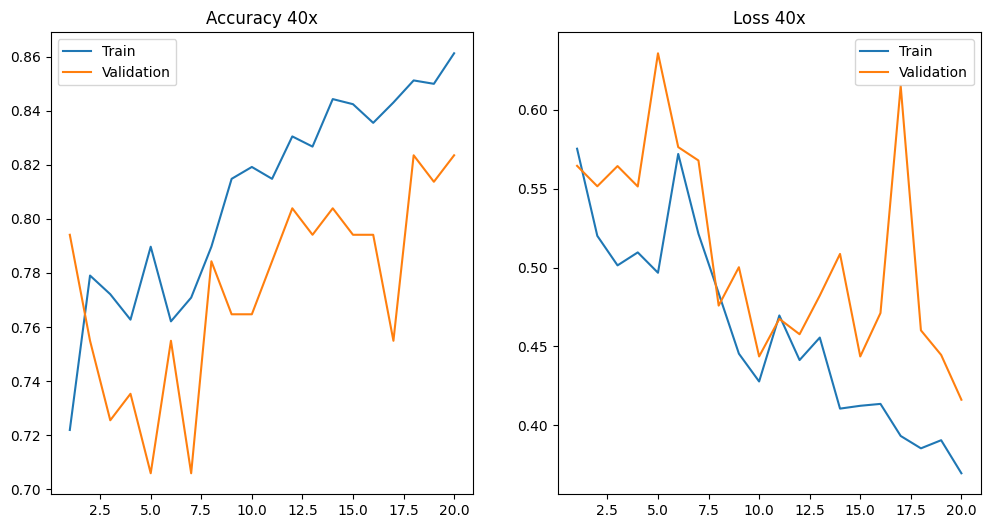

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(np.linspace(1, epochs, epochs), accuracy_40x["train"], label="Train")
axs[0].plot(np.linspace(1, epochs, epochs), accuracy_40x["val"], label="Validation")
axs[1].plot(np.linspace(1, epochs, epochs), loss_40x["train"], label="Train")
axs[1].plot(np.linspace(1, epochs, epochs), loss_40x["val"], label="Validation")
axs[0].legend()
axs[1].legend()
axs[0].title.set_text('Accuracy 40x')
axs[1].title.set_text('Loss 40x')
plt.show()

In [14]:
magn = "100X"

model = ABMILModel()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
best_params_100x, accuracy_100x, loss_100x = train_model(model, loaders[magn], criterion, optimizer, num_epochs=epochs)

Epoch 1/20
----------
train Loss: 0.5412 Acc: 0.7520
val Loss: 0.5782 Acc: 0.7103

Epoch 2/20
----------
train Loss: 0.4699 Acc: 0.8031
val Loss: 0.4854 Acc: 0.7570

Epoch 3/20
----------
train Loss: 0.4794 Acc: 0.8001
val Loss: 0.3523 Acc: 0.8692

Epoch 4/20
----------
train Loss: 0.5168 Acc: 0.8236
val Loss: 0.3174 Acc: 0.8692

Epoch 5/20
----------
train Loss: 0.4141 Acc: 0.8453
val Loss: 0.3883 Acc: 0.8692

Epoch 6/20
----------
train Loss: 0.4014 Acc: 0.8393
val Loss: 0.3408 Acc: 0.8598

Epoch 7/20
----------
train Loss: 0.4385 Acc: 0.8561
val Loss: 0.3257 Acc: 0.8505

Epoch 8/20
----------
train Loss: 0.3858 Acc: 0.8543
val Loss: 0.2944 Acc: 0.8692

Epoch 9/20
----------
train Loss: 0.3507 Acc: 0.8651
val Loss: 0.2182 Acc: 0.9252

Epoch 10/20
----------
train Loss: 0.3605 Acc: 0.8573
val Loss: 0.2724 Acc: 0.9159

Epoch 11/20
----------
train Loss: 0.3551 Acc: 0.8663
val Loss: 0.2554 Acc: 0.9065

Epoch 12/20
----------
train Loss: 0.3537 Acc: 0.8675
val Loss: 0.2816 Acc: 0.9159

E

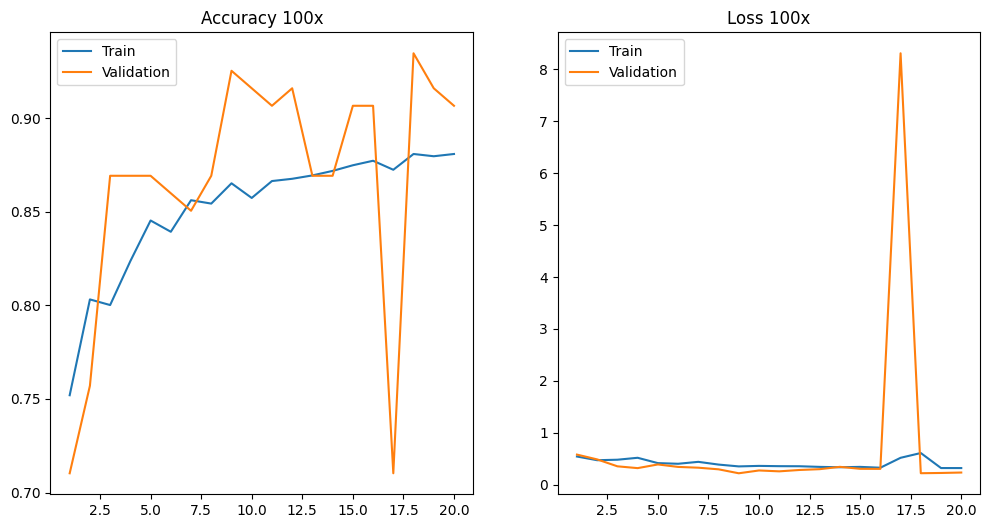

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(np.linspace(1, epochs, epochs), accuracy_100x["train"], label="Train")
axs[0].plot(np.linspace(1, epochs, epochs), accuracy_100x["val"], label="Validation")
axs[1].plot(np.linspace(1, epochs, epochs), loss_100x["train"], label="Train")
axs[1].plot(np.linspace(1, epochs, epochs), loss_100x["val"], label="Validation")
axs[0].legend()
axs[1].legend()
axs[0].title.set_text('Accuracy 100x')
axs[1].title.set_text('Loss 100x')
plt.show()

In [ ]:
magn = "200X"

model = ABMILModel()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
best_params_200x, accuracy_200x, loss_200x = train_model(model, loaders[magn], criterion, optimizer, num_epochs=epochs)

Epoch 1/20
----------
train Loss: 0.5122 Acc: 0.7805
val Loss: 2.7027 Acc: 0.7087

Epoch 2/20
----------
train Loss: 0.4217 Acc: 0.8377
val Loss: 0.3772 Acc: 0.8641

Epoch 3/20
----------
train Loss: 0.4116 Acc: 0.8458
val Loss: 0.4155 Acc: 0.8252

Epoch 4/20
----------
train Loss: 0.4200 Acc: 0.8408
val Loss: 0.3473 Acc: 0.8544

Epoch 5/20
----------
train Loss: 0.4251 Acc: 0.8346
val Loss: 0.3582 Acc: 0.8544

Epoch 6/20
----------
train Loss: 0.3907 Acc: 0.8526
val Loss: 0.4305 Acc: 0.8155

Epoch 7/20
----------
train Loss: 0.4053 Acc: 0.8476
val Loss: 0.2601 Acc: 0.8932

Epoch 8/20
----------
train Loss: 0.4353 Acc: 0.8209
val Loss: 0.3394 Acc: 0.8641

Epoch 9/20
----------
train Loss: 0.4035 Acc: 0.8483
val Loss: 0.3560 Acc: 0.8835

Epoch 10/20
----------
train Loss: 0.3847 Acc: 0.8358
val Loss: 0.3710 Acc: 0.8447

Epoch 11/20
----------
train Loss: 0.3791 Acc: 0.8458
val Loss: 0.3221 Acc: 0.8835

Epoch 12/20
----------
train Loss: 0.3582 Acc: 0.8632
val Loss: 0.3805 Acc: 0.8641

E

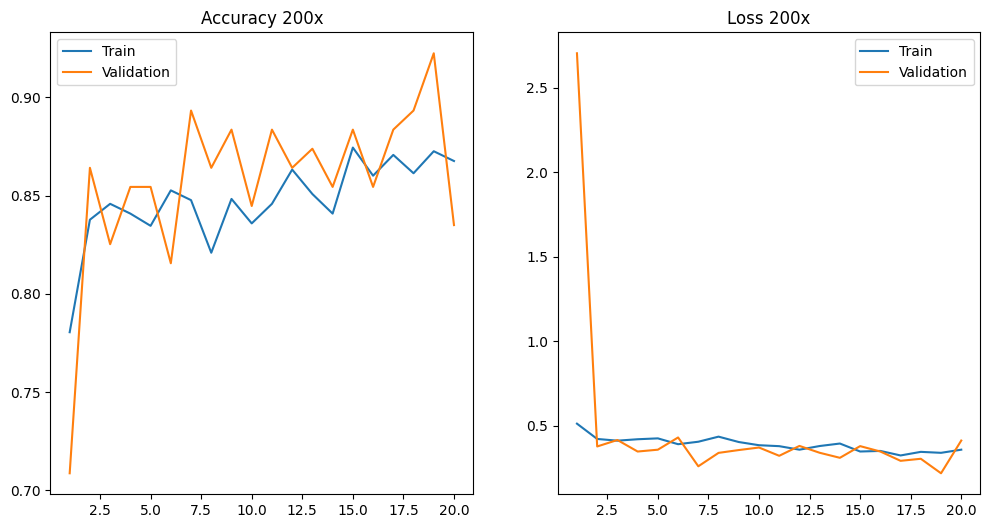

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(np.linspace(1, epochs, epochs), accuracy_200x["train"], label="Train")
axs[0].plot(np.linspace(1, epochs, epochs), accuracy_200x["val"], label="Validation")
axs[1].plot(np.linspace(1, epochs, epochs), loss_200x["train"], label="Train")
axs[1].plot(np.linspace(1, epochs, epochs), loss_200x["val"], label="Validation")
axs[0].legend()
axs[1].legend()
axs[0].title.set_text('Accuracy 200x')
axs[1].title.set_text('Loss 200x')
plt.show()

In [ ]:
magn = "400X"

model = ABMILModel()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
best_params_400x, accuracy_400x, loss_400x = train_model(model, loaders[magn], criterion, optimizer, num_epochs=epochs)

Epoch 1/20
----------
train Loss: 0.5761 Acc: 0.7249
val Loss: 0.3892 Acc: 0.8495

Epoch 2/20
----------
train Loss: 0.5328 Acc: 0.7620
val Loss: 0.5240 Acc: 0.7527

Epoch 3/20
----------
train Loss: 0.5005 Acc: 0.7916
val Loss: 0.5581 Acc: 0.6882

Epoch 4/20
----------
train Loss: 0.5893 Acc: 0.7772
val Loss: 0.4943 Acc: 0.8387

Epoch 5/20
----------
train Loss: 0.6853 Acc: 0.8019
val Loss: 0.4547 Acc: 0.8065

Epoch 6/20
----------
train Loss: 0.4567 Acc: 0.8102
val Loss: 1.4993 Acc: 0.8280

Epoch 7/20
----------
train Loss: 0.4649 Acc: 0.8109
val Loss: 0.4025 Acc: 0.8065

Epoch 8/20
----------
train Loss: 0.4509 Acc: 0.8212
val Loss: 0.3546 Acc: 0.8495

Epoch 9/20
----------
train Loss: 0.4268 Acc: 0.8370
val Loss: 0.4215 Acc: 0.8387

Epoch 10/20
----------
train Loss: 0.4237 Acc: 0.8246
val Loss: 0.4472 Acc: 0.8065

Epoch 11/20
----------
train Loss: 0.4095 Acc: 0.8274
val Loss: 0.3619 Acc: 0.8710

Epoch 12/20
----------
train Loss: 0.3909 Acc: 0.8349
val Loss: 0.3369 Acc: 0.8495

E

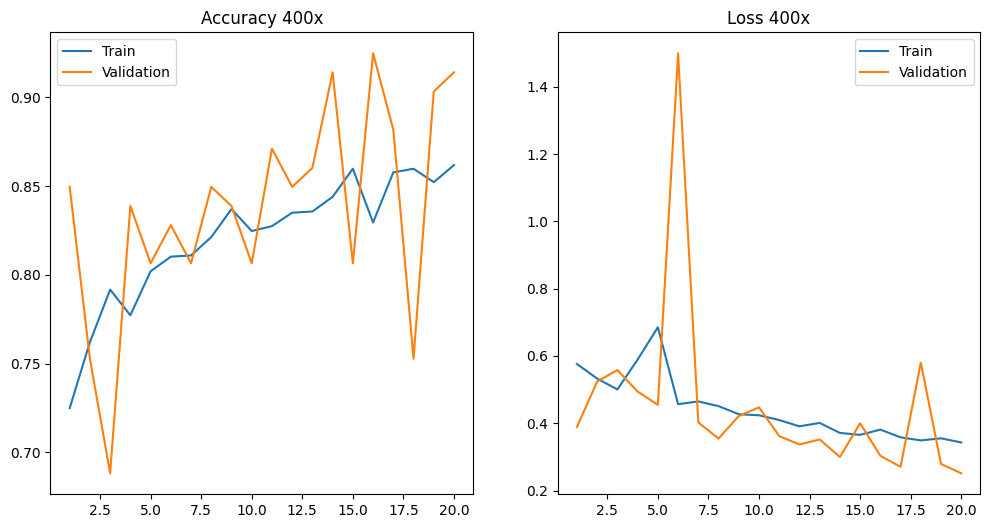

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(np.linspace(1, epochs, epochs), accuracy_400x["train"], label="Train")
axs[0].plot(np.linspace(1, epochs, epochs), accuracy_400x["val"], label="Validation")
axs[1].plot(np.linspace(1, epochs, epochs), loss_400x["train"], label="Train")
axs[1].plot(np.linspace(1, epochs, epochs), loss_400x["val"], label="Validation")
axs[0].legend()
axs[1].legend()
axs[0].title.set_text('Accuracy 400x')
axs[1].title.set_text('Loss 400x')
plt.show()

## Evaluation

In [16]:
def test(model, loader, criterion):
  model.eval()
  with torch.no_grad():
    running_loss = 0.0
    running_corrects = 0

    for patches, tag in loader['test']:
      patches = patches.squeeze(0)
      patches = patches.to(device)
      tag = tag.to(device)

      pred = model(patches)
      loss = criterion(pred.reshape(-1), tag.float())

      running_loss += loss.item()
      running_corrects += (pred.round().item() == tag.item())

  loss = running_loss / len(loader['test'])
  accuracy = running_corrects / len(loader['test'])

  return accuracy, loss

In [ ]:
magn = "40X"
model = ABMILModel()
model.load_state_dict(best_params_40x)
model.to(device)

accuracy_40, loss_40 = test(model, loaders[magn], criterion)
print(magn, 'Accuracy:', accuracy_40, 'Loss:', loss_40)

40X Accuracy: 0.89 Loss: 0.31818984554650354


In [17]:
magn = "100X"
model = ABMILModel()
model.load_state_dict(best_params_100x)
model.to(device)

accuracy_100, loss_100 = test(model, loaders[magn], criterion)
print(magn, 'Accuracy:', accuracy_100, 'Loss:', loss_100)

100X Accuracy: 0.9137380191693291 Loss: 0.2599129214083287


In [ ]:
magn = "200X"
model = ABMILModel()
model.load_state_dict(best_params_200x)
model.to(device)

accuracy_200, loss_200 = test(model, loaders[magn], criterion)
print(magn, 'Accuracy:', accuracy_200, 'Loss:', loss_200)

200X Accuracy: 0.8973509933774835 Loss: 0.29473207586308675


In [ ]:
magn = "400X"
model = ABMILModel()
model.load_state_dict(best_params_400x)
model.to(device)

accuracy_400, loss_400 = test(model, loaders[magn], criterion)
print(magn, 'Accuracy:', accuracy_400, 'Loss:', loss_400)

400X Accuracy: 0.8937728937728938 Loss: 0.29868049380075673
